**Author: *Abdul Hanan Bin Saeed***

**Action Learning Team: 7**

**Specialization: *DSA***

# **PERFORMING INFERENCE USING FINETUNED GPT-2 MODEL ON UNKNOWN DATA**


**Objective**

In this notebook, our aim is to test the workability of the already finetuned GPT-2 model, and test it's text summarization capabilities on unknown data. For this purpose, we utilize CNN Dailymail Dataset (Version 3.0.0). 

**Dataset Info**


**CNN Dailymail Dataset (Version 3.0.0)**

How to access the Dataset: https://huggingface.co/datasets/abisee/cnn_dailymail

* The dataset consists of 3 data fields; id, article, highlights
* The CNN/DailyMail dataset has 3 splits: train, validation, and test. With 287 113, 13 368 and 11 490 records respectively.
* The language of each record in this dataset is English.

Further information about the Datasets is provided on the Hugging Face website.

**Importing Relevant Libraries**

In [1]:
!pip install transformers datasets peft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 6.3 MB/s eta 0:00:0000:01


In [2]:
%%time
import os
from transformers import set_seed, GPT2Tokenizer, GPT2LMHeadModel, pipeline
from peft import PeftModel, PeftConfig
from datasets import load_dataset

2024-07-15 12:17:10.005878: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-15 12:17:10.005985: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-15 12:17:10.152549: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


CPU times: user 11.3 s, sys: 1.81 s, total: 13.1 s
Wall time: 19.5 s


**Defining the Paths to Finetuned Model and Tokenizer**

In [3]:
# Define the paths
model_directory = "/kaggle/input/gpt2-finetuned-1/other/2/1/model"  

In [4]:
# Load the tokenizer
tokenizer = GPT2Tokenizer.from_pretrained(model_directory)

In [5]:
# Load the base GPT-2 model
base_model_name = "gpt2"
original_model = GPT2LMHeadModel.from_pretrained(base_model_name)

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [6]:
# Load the adapter configuration and model
adapter_config = PeftConfig.from_pretrained(model_directory)
ft_model = PeftModel.from_pretrained(original_model, model_directory, config=adapter_config)


/opt/conda/lib/python3.10/site-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


**Loading the Dataset**

In [7]:
# Create a pipeline for text generation
gen = pipeline("text-generation", model=original_model, tokenizer=tokenizer)

In [8]:
from datasets import load_dataset 
# Load the CNN/DailyMail dataset
df = load_dataset("abisee/cnn_dailymail", "3.0.0")
df['test'][0]


Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

{'article': '(CNN)The Palestinian Authority officially became the 123rd member of the International Criminal Court on Wednesday, a step that gives the court jurisdiction over alleged crimes in Palestinian territories. The formal accession was marked with a ceremony at The Hague, in the Netherlands, where the court is based. The Palestinians signed the ICC\'s founding Rome Statute in January, when they also accepted its jurisdiction over alleged crimes committed "in the occupied Palestinian territory, including East Jerusalem, since June 13, 2014." Later that month, the ICC opened a preliminary examination into the situation in Palestinian territories, paving the way for possible war crimes investigations against Israelis. As members of the court, Palestinians may be subject to counter-charges as well. Israel and the United States, neither of which is an ICC member, opposed the Palestinians\' efforts to join the body. But Palestinian Foreign Minister Riad al-Malki, speaking at Wednesday

**Using different prompts to Test the Finetuned model**

In [11]:
# Select an index from the dataset
index = 5

# Get the article and highlights for the selected index
article = df['test'][index]['article']
highlights = df['test'][index]['highlights']

# Format the input prompt
formatted_prompt = f"Please summarize the following article for zero-shot purposes:\n\n{article}\n\nSummary:\n"

# Generate the summary with adjusted parameters
res = gen(formatted_prompt, max_new_tokens=50, num_return_sequences=1, temperature=0.25, top_p=0.30, top_k=75)

# Extract the generated output
generated_text = res[0]['generated_text']
output = generated_text.split('Summary:\n')[1].strip() if 'Summary:\n' in generated_text else "No output generated."

# Post-processing to remove repetitive sentences
output_lines = output.split('. ')
unique_lines = []
for line in output_lines:
    if line not in unique_lines:
        unique_lines.append(line)
cleaned_output = '. '.join(unique_lines)

# Print the results
dash_line = '-' * 100
print(dash_line)
print(f'INPUT PROMPT:\n{formatted_prompt}')
print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{highlights}\n')
print(dash_line)
print(f'MODEL GENERATION - ZERO SHOT:\n{cleaned_output}')

----------------------------------------------------------------------------------------------------
INPUT PROMPT:
Please summarize the following article for zero-shot purposes:

(CNN)He's a blue chip college basketball recruit. She's a high school freshman with Down syndrome. At first glance Trey Moses and Ellie Meredith couldn't be more different. But all that changed Thursday when Trey asked Ellie to be his prom date. Trey -- a star on Eastern High School's basketball team in Louisville, Kentucky, who's headed to play college ball next year at Ball State -- was originally going to take his girlfriend to Eastern's prom. So why is he taking Ellie instead? "She's great... she listens and she's easy to talk to" he said. Trey made the prom-posal (yes, that's what they are calling invites to prom these days) in the gym during Ellie's P.E. class. Trina Helson, a teacher at Eastern, alerted the school's newspaper staff to the prom-posal and posted photos of Trey and Ellie on Twitter that ha

In [12]:
# Select an index from the dataset
index = 12

# Get the article and highlights for the selected index
article = df['test'][index]['article']
highlights = df['test'][index]['highlights']

# Format the input prompt
formatted_prompt = f"Summarize the following article for zero-shot purposes concisely:\n\n{article}\n\nSummary:\n"

# Generate the summary with adjusted parameters
res = gen(formatted_prompt, max_new_tokens=50, num_return_sequences=1, temperature=0.25, top_p=0.30, top_k=75)

# Extract the generated output
generated_text = res[0]['generated_text']
output = generated_text.split('Summary:\n')[1].strip() if 'Summary:\n' in generated_text else "No output generated."

# Post-processing to remove repetitive sentences
output_lines = output.split('. ')
unique_lines = []
for line in output_lines:
    if line not in unique_lines:
        unique_lines.append(line)
cleaned_output = '. '.join(unique_lines)

# Print the results
dash_line = '-' * 100
print(dash_line)
print(f'INPUT PROMPT:\n{formatted_prompt}')
print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{highlights}\n')
print(dash_line)
print(f'MODEL GENERATION - ZERO SHOT:\n{cleaned_output}')

----------------------------------------------------------------------------------------------------
INPUT PROMPT:
Summarize the following article for zero-shot purposes concisely:

(CNN)Seventy years ago, Anne Frank died of typhus in a Nazi concentration camp at the age of 15. Just two weeks after her supposed death on March 31, 1945, the Bergen-Belsen concentration camp where she had been imprisoned was liberated -- timing that showed how close the Jewish diarist had been to surviving the Holocaust. But new research released by the Anne Frank House shows that Anne and her older sister, Margot Frank, died at least a month earlier than previously thought. Researchers re-examined archives of the Red Cross, the International Training Service and the Bergen-Belsen Memorial, along with testimonies of survivors. They concluded that Anne and Margot probably did not survive to March 1945 -- contradicting the date of death which had previously been determined by Dutch authorities. In 1944, Ann

In [13]:
# Select an index from the dataset
index = 8

# Get the article and highlights for the selected index
article = df['test'][index]['article']
highlights = df['test'][index]['highlights']

# Format the input prompt
formatted_prompt = f"Summarize the following article:\n\n{article}\n\nSummary:\n"

# Generate the summary with adjusted parameters
res = gen(formatted_prompt, max_new_tokens=50, num_return_sequences=1, temperature=0.25, top_p=0.30, top_k=75)

# Extract the generated output
generated_text = res[0]['generated_text']
output = generated_text.split('Summary:\n')[1].strip() if 'Summary:\n' in generated_text else "No output generated."

# Post-processing to remove repetitive sentences
output_lines = output.split('. ')
unique_lines = []
for line in output_lines:
    if line not in unique_lines:
        unique_lines.append(line)
cleaned_output = '. '.join(unique_lines)

# Print the results
dash_line = '-' * 100
print(dash_line)
print(f'INPUT PROMPT:\n{formatted_prompt}')
print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{highlights}\n')
print(dash_line)
print(f'MODEL GENERATION - ZERO SHOT:\n{cleaned_output}')

----------------------------------------------------------------------------------------------------
INPUT PROMPT:
Summarize the following article:

(CNN)Filipinos are being warned to be on guard for flash floods and landslides as tropical storm Maysak approached the Asian island nation Saturday. Just a few days ago, Maysak gained super typhoon status thanks to its sustained 150 mph winds. It has since lost a lot of steam as it has spun west in the Pacific Ocean. It's now classified as a tropical storm, according to the Philippine national weather service, which calls it a different name, Chedeng. It boasts steady winds of more than 70 mph (115 kph) and gusts up to 90 mph as of 5 p.m. (5 a.m. ET) Saturday. Still, that doesn't mean Maysak won't pack a wallop. Authorities took preemptive steps to keep people safe such as barring outdoor activities like swimming, surfing, diving and boating in some locales, as well as a number of precautionary evacuations. Gabriel Llave, a disaster offici

**Testing with Original Model vs Testing with Finetuned Model**

In [17]:
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    GenerationConfig
)
import torch
import time
import pandas as pd
import numpy as np
from huggingface_hub import interpreter_login

interpreter_login()


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .


Enter your token (input will not be visible):  ·····································
Add token as git credential? (Y/n)  n


Token is valid (permission: fineGrained).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [18]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

base_model_gpt = "openai-community/gpt2"
gpt_model = AutoModelForCausalLM.from_pretrained(base_model_gpt, 
                                                      device_map='auto',
                                                      trust_remote_code=True,
                                                      use_auth_token=True)

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [19]:
eval_tokenizer = AutoTokenizer.from_pretrained(base_model_gpt, add_bos_token=True, trust_remote_code=True, use_fast=False)
eval_tokenizer.pad_token = eval_tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [20]:
# Set a seed for reproducibility
from transformers import pipeline, set_seed
import torch
seed = 42
set_seed(seed)

In [21]:
from transformers import pipeline, GPT2Tokenizer, GPT2LMHeadModel
import pandas as pd

# Load the pre-trained GPT-2 model and tokenizer
gpt_model = GPT2LMHeadModel.from_pretrained("gpt2")
eval_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Load your fine-tuned model and corresponding tokenizer
# Assume `original_model` is your fine-tuned model name or path
peft_model = GPT2LMHeadModel.from_pretrained("/kaggle/input/gpt2-finetuned-1/other/2/1/model")
peft_tokenizer = GPT2Tokenizer.from_pretrained("/kaggle/input/gpt2-finetuned-1/other/2/1/model")

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [22]:
articles = df['test'][0:10]['article']
human_baseline_summaries = df['test'][0:10]['highlights']

original_model_summaries = []
peft_model_summaries = []

# Initialize pipelines
original_model_gen = pipeline("text-generation", model=gpt_model, tokenizer=eval_tokenizer)
peft_model_gen = pipeline("text-generation", model=peft_model, tokenizer=peft_tokenizer)

for idx, article in enumerate(articles):
    human_baseline_text_output = human_baseline_summaries[idx]
    prompt = f"Instruct: Summarize the following Article.\n{article}\nOutput:\n"
    
    try:
        original_model_res = original_model_gen(prompt, max_new_tokens=50, num_return_sequences=1, temperature=0.25, top_p=0.30, top_k=75)
        full_generated_text = original_model_res[0]['generated_text']
        print(f"Original Model Generated Text at index {idx}: {full_generated_text}")
        original_model_text_output = full_generated_text.split('Output:\n')[1].strip() if 'Output:\n' in full_generated_text else "No output generated."
    except Exception as e:
        print(f"Error generating with original model at index {idx}: {e}")
        original_model_text_output = "Error during generation."
    
    try:
        peft_model_res = peft_model_gen(prompt, max_new_tokens=50, num_return_sequences=1, temperature=0.25, top_p=0.30, top_k=75)
        full_generated_text = peft_model_res[0]['generated_text']
        print(f"PEFT Model Generated Text at index {idx}: {full_generated_text}")
        peft_model_text_output = full_generated_text.split('Output:\n')[1].strip() if 'Output:\n' in full_generated_text else "No output generated."
    except Exception as e:
        print(f"Error generating with PEFT model at index {idx}: {e}")
        peft_model_text_output = "Error during generation."

    original_model_summaries.append(original_model_text_output)
    peft_model_summaries.append(peft_model_text_output)

# Create DataFrame
df_metrics = pd.DataFrame({
    'human_baseline_summaries': human_baseline_summaries,
    'original_model_summaries': original_model_summaries,
    'peft_model_summaries': peft_model_summaries
})

print(df_metrics)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Original Model Generated Text at index 0: Instruct: Summarize the following Article.
(CNN)The Palestinian Authority officially became the 123rd member of the International Criminal Court on Wednesday, a step that gives the court jurisdiction over alleged crimes in Palestinian territories. The formal accession was marked with a ceremony at The Hague, in the Netherlands, where the court is based. The Palestinians signed the ICC's founding Rome Statute in January, when they also accepted its jurisdiction over alleged crimes committed "in the occupied Palestinian territory, including East Jerusalem, since June 13, 2014." Later that month, the ICC opened a preliminary examination into the situation in Palestinian territories, paving the way for possible war crimes investigations against Israelis. As members of the court, Palestinians may be subject to counter-charges as well. Israel and the United States, neither of which is an ICC member, opposed the Palestinians' efforts to join the body.

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


PEFT Model Generated Text at index 0: Instruct: Summarize the following Article.
(CNN)The Palestinian Authority officially became the 123rd member of the International Criminal Court on Wednesday, a step that gives the court jurisdiction over alleged crimes in Palestinian territories. The formal accession was marked with a ceremony at The Hague, in the Netherlands, where the court is based. The Palestinians signed the ICC's founding Rome Statute in January, when they also accepted its jurisdiction over alleged crimes committed "in the occupied Palestinian territory, including East Jerusalem, since June 13, 2014." Later that month, the ICC opened a preliminary examination into the situation in Palestinian territories, paving the way for possible war crimes investigations against Israelis. As members of the court, Palestinians may be subject to counter-charges as well. Israel and the United States, neither of which is an ICC member, opposed the Palestinians' efforts to join the body. But

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


PEFT Model Generated Text at index 1: Instruct: Summarize the following Article.
(CNN)Never mind cats having nine lives. A stray pooch in Washington State has used up at least three of her own after being hit by a car, apparently whacked on the head with a hammer in a misguided mercy killing and then buried in a field -- only to survive. That's according to Washington State University, where the dog -- a friendly white-and-black bully breed mix now named Theia -- has been receiving care at the Veterinary Teaching Hospital. Four days after her apparent death, the dog managed to stagger to a nearby farm, dirt-covered and emaciated, where she was found by a worker who took her to a vet for help. She was taken in by Moses Lake, Washington, resident Sara Mellado. "Considering everything that she's been through, she's incredibly gentle and loving," Mellado said, according to WSU News. "She's a true miracle dog and she deserves a good life." Theia is only one year old but the dog's brush with

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


PEFT Model Generated Text at index 2: Instruct: Summarize the following Article.
(CNN)If you've been following the news lately, there are certain things you doubtless know about Mohammad Javad Zarif. He is, of course, the Iranian foreign minister. He has been U.S. Secretary of State John Kerry's opposite number in securing a breakthrough in nuclear discussions that could lead to an end to sanctions against Iran -- if the details can be worked out in the coming weeks. And he received a hero's welcome as he arrived in Iran on a sunny Friday morning. "Long live Zarif," crowds chanted as his car rolled slowly down the packed street. You may well have read that he is "polished" and, unusually for one burdened with such weighty issues, "jovial." An Internet search for "Mohammad Javad Zarif" and "jovial" yields thousands of results. He certainly has gone a long way to bring Iran in from the cold and allow it to rejoin the international community. But there are some facts about Zarif that are 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


PEFT Model Generated Text at index 3: Instruct: Summarize the following Article.
(CNN)Five Americans who were monitored for three weeks at an Omaha, Nebraska, hospital after being exposed to Ebola in West Africa have been released, a Nebraska Medicine spokesman said in an email Wednesday. One of the five had a heart-related issue on Saturday and has been discharged but hasn't left the area, Taylor Wilson wrote. The others have already gone home. They were exposed to Ebola in Sierra Leone in March, but none developed the deadly virus. They are clinicians for Partners in Health, a Boston-based aid group. They all had contact with a colleague who was diagnosed with the disease and is being treated at the National Institutes of Health in Bethesda, Maryland. As of Monday, that health care worker is in fair condition. The Centers for Disease Control and Prevention in Atlanta has said the last of 17 patients who were being monitored are expected to be released by Thursday. More than 10,000 pe

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


PEFT Model Generated Text at index 4: Instruct: Summarize the following Article.
(CNN)A Duke student has admitted to hanging a noose made of rope from a tree near a student union, university officials said Thursday. The prestigious private school didn't identify the student, citing federal privacy laws. In a news release, it said the student was no longer on campus and will face student conduct review. The student was identified during an investigation by campus police and the office of student affairs and admitted to placing the noose on the tree early Wednesday, the university said. Officials are still trying to determine if other people were involved. Criminal investigations into the incident are ongoing as well. Students and faculty members marched Wednesday afternoon chanting "We are not afraid. We stand together,"  after pictures of the noose were passed around on social media. At a forum held on the steps of Duke Chapel, close to where the noose was discovered at 2 a.m., hundred

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


PEFT Model Generated Text at index 5: Instruct: Summarize the following Article.
(CNN)He's a blue chip college basketball recruit. She's a high school freshman with Down syndrome. At first glance Trey Moses and Ellie Meredith couldn't be more different. But all that changed Thursday when Trey asked Ellie to be his prom date. Trey -- a star on Eastern High School's basketball team in Louisville, Kentucky, who's headed to play college ball next year at Ball State -- was originally going to take his girlfriend to Eastern's prom. So why is he taking Ellie instead? "She's great... she listens and she's easy to talk to" he said. Trey made the prom-posal (yes, that's what they are calling invites to prom these days) in the gym during Ellie's P.E. class. Trina Helson, a teacher at Eastern, alerted the school's newspaper staff to the prom-posal and posted photos of Trey and Ellie on Twitter that have gone viral. She wasn't surpristed by Trey's actions. "That's the kind of person Trey is," she s

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


PEFT Model Generated Text at index 6: Instruct: Summarize the following Article.
(CNN)Governments around the world are using the threat of terrorism -- real or perceived -- to advance executions, Amnesty International alleges in its annual report on the death penalty. "The dark trend of governments using the death penalty in a futile attempt to tackle real or imaginary threats to state security and public safety was stark last year," said Salil Shetty, Amnesty's Secretary General in a release. "It is shameful that so many states around the world are essentially playing with people's lives -- putting people to death for 'terrorism' or to quell internal instability on the ill-conceived premise of deterrence." The report, "Death Sentences and Executions 2014," cites the example of Pakistan lifting a six-year moratorium on the execution of civilians following the horrific attack on a school in Peshawar in December. China is also mentioned, as having used the death penalty as a tool in its 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


PEFT Model Generated Text at index 7: Instruct: Summarize the following Article.
(CNN)Andrew Getty, one of the heirs to billions of oil money, appears to have died of natural causes, a Los Angeles Police Department spokesman said. The coroner's preliminary assessment is there was no foul play involved in the death of Getty, grandson of oil tycoon J. Paul Getty, said Detective Meghan Aguilar. Andrew Getty, 47, had "several health issues," Aguilar said, adding that an autopsy will be conducted. There is no criminal investigation underway, he said. Some medication had also been recovered from Getty's home, though investigators don't know whether Getty was taking it or what his medical history was, Ed Winter, assistant chief in the Los Angeles County coroner's office, told CNN affiliate KTLA Tuesday night. KTLA reported that Getty was found on his side near a bathroom in his home. Getty's parents, Ann and Gordon Getty, released a statement confirming their son's death and asking for privac

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


PEFT Model Generated Text at index 8: Instruct: Summarize the following Article.
(CNN)Filipinos are being warned to be on guard for flash floods and landslides as tropical storm Maysak approached the Asian island nation Saturday. Just a few days ago, Maysak gained super typhoon status thanks to its sustained 150 mph winds. It has since lost a lot of steam as it has spun west in the Pacific Ocean. It's now classified as a tropical storm, according to the Philippine national weather service, which calls it a different name, Chedeng. It boasts steady winds of more than 70 mph (115 kph) and gusts up to 90 mph as of 5 p.m. (5 a.m. ET) Saturday. Still, that doesn't mean Maysak won't pack a wallop. Authorities took preemptive steps to keep people safe such as barring outdoor activities like swimming, surfing, diving and boating in some locales, as well as a number of precautionary evacuations. Gabriel Llave, a disaster official, told PNA that tourists who arrive Saturday in and around the coa

**Evaluation Metrics**

In [24]:
!pip install -q -U evaluate rouge_score

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [27]:
import evaluate

rouge = evaluate.load('rouge')

original_model_results = rouge.compute(
    predictions=original_model_summaries,
    references=human_baseline_summaries[0:len(original_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

peft_model_results = rouge.compute(
    predictions=peft_model_summaries,
    references=human_baseline_summaries[0:len(peft_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

print('ORIGINAL MODEL:')
print(original_model_results)
print('PEFT MODEL:')
print(peft_model_results)

print("Absolute percentage improvement of PEFT MODEL over ORIGINAL MODEL")

improvement = (np.array(list(peft_model_results.values())) - np.array(list(original_model_results.values()))) * 100
improvement_dict = {key: value for key, value in zip(peft_model_results.keys(), improvement)}

for key, value in improvement_dict.items():
    print(f'{key}: {value:.2f}%')

ORIGINAL MODEL:
{'rouge1': 0.13825596400933732, 'rouge2': 0.019107740657238505, 'rougeL': 0.11442176638953251, 'rougeLsum': 0.11056323944254978}
PEFT MODEL:
{'rouge1': 0.25089395913952395, 'rouge2': 0.07170702038483809, 'rougeL': 0.16166327764767202, 'rougeLsum': 0.2064826384532698}
Absolute percentage improvement of PEFT MODEL over ORIGINAL MODEL
rouge1: 11.26%
rouge2: 5.26%
rougeL: 4.72%
rougeLsum: 9.59%


**Visualizing the Metrics**

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


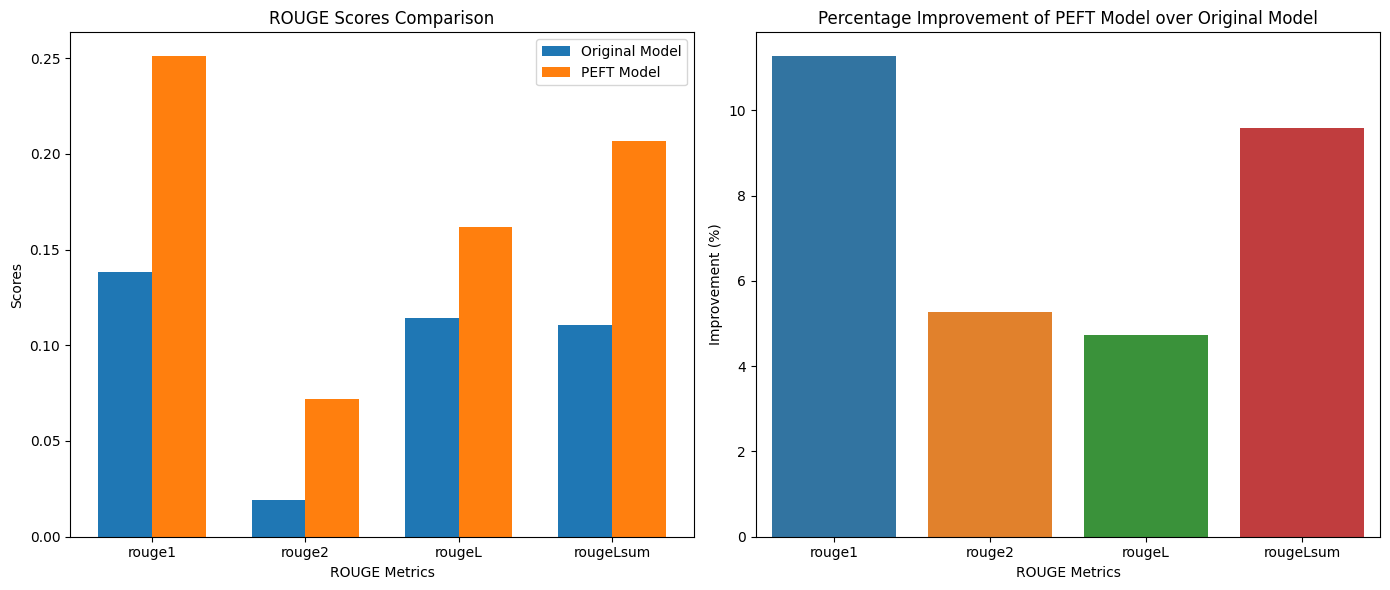

In [30]:
# Visualization
metrics = list(original_model_results.keys())
original_scores = list(original_model_results.values())
peft_scores = list(peft_model_results.values())
improvement_scores = list(improvement_dict.values())

# Set up the figure and axes
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Bar plot for ROUGE scores
bar_width = 0.35
x = np.arange(len(metrics))

axes[0].bar(x - bar_width/2, original_scores, bar_width, label='Original Model')
axes[0].bar(x + bar_width/2, peft_scores, bar_width, label='PEFT Model')

axes[0].set_xlabel('ROUGE Metrics')
axes[0].set_ylabel('Scores')
axes[0].set_title('ROUGE Scores Comparison')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics)
axes[0].legend()

# Bar plot for improvements
sns.barplot(x=metrics, y=improvement_scores, ax=axes[1])

axes[1].set_xlabel('ROUGE Metrics')
axes[1].set_ylabel('Improvement (%)')
axes[1].set_title('Percentage Improvement of PEFT Model over Original Model')

# Show plot
plt.tight_layout()
plt.show()

**Performing inference on a random generated text**

In [31]:
# User-provided input
user_input = """
In a quiet corner of the forest, a small cabin nestled among towering trees. Its weathered walls bore stories of solitude and resilience. Inside, the fireplace crackled warmly, casting flickering shadows on old books and a worn armchair. This sanctuary offered solace from the bustling world beyond its wooden door.
"""

# Format the input prompt
formatted_prompt = f"Please generate a summary based on the following input:\n\n{user_input}\n\nSummary:\n"

# Generate the summary with adjusted parameters
res = gen(formatted_prompt, max_new_tokens=50, num_return_sequences=1, temperature=0.25, top_p=0.30, top_k=75)

# Extract the generated summary text
generated_summary = res[0]['generated_text'].split('Summary:\n')[1].strip() if 'Summary:\n' in res[0]['generated_text'] else "No summary generated."

# Print the generated summary
print(f"Generated Summary:\n{generated_summary}")

Generated Summary:
Below is an instruction that describes the room.

### End
Below is an instruction that describes the room.

### End

### End

### End

### End

### End

### End

###
